<a href="https://colab.research.google.com/github/Cassembo/Univ_WP/blob/main/social_media_analyse_WP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Method one**

In [2]:
import pandas as pd

# Load the uploaded dataset to inspect its content
file_path = '/content/soufi_classification_data (2).csv'
data = pd.read_csv(file_path)

In [3]:
# Display basic information and the first few rows of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11116 entries, 0 to 11115
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  11112 non-null  object
 1   type      11116 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 173.8+ KB


In [4]:
data.head()

,sentence,type
0,انت قاعد تحلب وستاتي هاذا تقذف بيه في ناس تخدم...,0
1,وينه لي يفهم ياحصراه كي مايسرقوهاش كل راه لباس,0
2,وهي ديك لحية لواش يقلعك من دنيا,0
3,8 ركعات ركعتا الراتبة و 1 وتر 11 ركعة,0
4,لاحول ولاقوة الا بالله ملء كل شيء,1


In [5]:
from sklearn.utils import resample

# Check the class distribution
class_counts = data['type'].value_counts()

# Separate the data into majority and minority classes
majority_class = data[data['type'] == class_counts.idxmax()]
minority_classes = [data[data['type'] == cls] for cls in class_counts.index if cls != class_counts.idxmax()]

# Oversample minority classes to match the majority class size
balanced_data = majority_class.copy()
for minority_class_data in minority_classes:
    oversampled_data = resample(
        minority_class_data,
        replace=True,  # Allow sampling with replacement
        n_samples=len(majority_class),  # Match majority class size
        random_state=42
    )
    balanced_data = pd.concat([balanced_data, oversampled_data], axis=0)

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
balanced_class_counts = balanced_data['type'].value_counts()

balanced_data.info(), balanced_class_counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24768 entries, 0 to 24767
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  24764 non-null  object
 1   type      24768 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 387.1+ KB


(None,
 type
 1    8256
 0    8256
 2    8256
 Name: count, dtype: int64)

<ipython-input-6-7b32335458fe>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=balanced_data, palette='viridis')


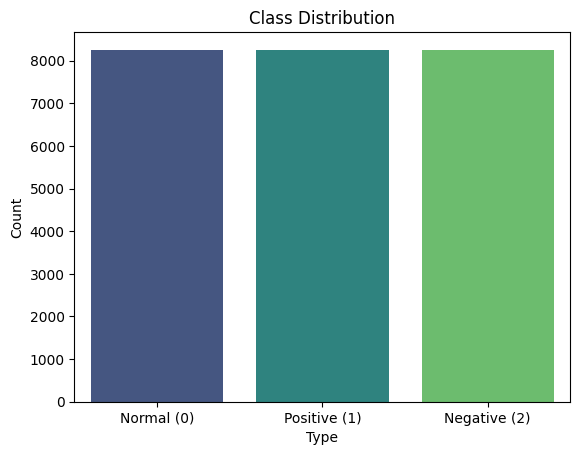

<ipython-input-6-7b32335458fe>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='sentence_length', data=balanced_data, palette='viridis')


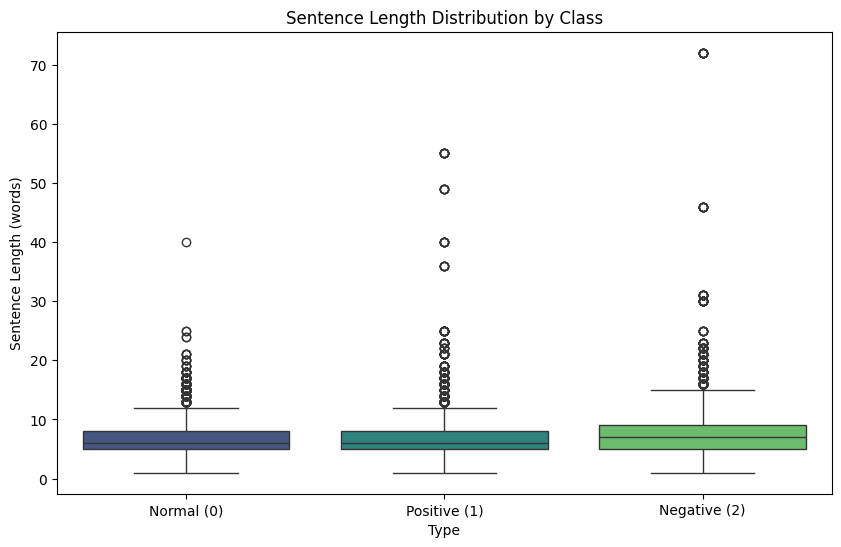

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
0,8252.0,6.527508,3.373540,1.0,5.0,6.0,8.0,40.0
1,8256.0,7.162791,3.537687,1.0,5.0,6.0,8.0,55.0
2,8256.0,7.471294,4.256910,1.0,5.0,7.0,9.0,72.0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize class distribution
sns.countplot(x='type', data=balanced_data, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Normal (0)', 'Positive (1)', 'Negative (2)'])
plt.show()

# Add a column for sentence lengths (number of words)
balanced_data['sentence_length'] = balanced_data['sentence'].dropna().apply(lambda x: len(str(x).split()))

# Sentence length distribution per class
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='sentence_length', data=balanced_data, palette='viridis')
plt.title('Sentence Length Distribution by Class')
plt.xlabel('Type')
plt.ylabel('Sentence Length (words)')
plt.xticks(ticks=[0, 1, 2], labels=['Normal (0)', 'Positive (1)', 'Negative (2)'])
plt.show()

# Summary statistics for sentence lengths
length_stats = balanced_data.groupby('type')['sentence_length'].describe()
length_stats


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for preprocessing
max_words = 10000  # Maximum number of unique words in the tokenizer
max_len = 50       # Maximum sequence length

# Drop rows with missing sentences
balanced_data = balanced_data.dropna(subset=['sentence'])

# Split data into features and labels
X = balanced_data['sentence']
y = balanced_data['type']

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Padding sequences
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Display shapes of train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19811, 50), (4953, 50), (19811,), (4953,))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [16]:
# Encode labels if not already encoded
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [17]:
# Convert labels to categorical if it's a classification task with more than 2 classes
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [18]:
# Parameters
embedding_dim = 100  # Dimension of word embeddings
num_classes = y_train_cat.shape[1]  # Number of unique labels/classes

In [21]:
# 1. GRU Model
def build_gru_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        GRU(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        GRU(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model()
gru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 2. LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# 3. RNN Model
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        SimpleRNN(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training Example for RNN Model
rnn_Hist = rnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.3304 - loss: 1.1187 - val_accuracy: 0.3358 - val_loss: 1.0983
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.3280 - loss: 1.0987 - val_accuracy: 0.3277 - val_loss: 1.0981
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3298 - loss: 1.0983 - val_accuracy: 0.3358 - val_loss: 1.0975
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3407 - loss: 1.0976 - val_accuracy: 0.3388 - val_loss: 1.0973
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3299 - loss: 1.0980 - val_accuracy: 0.3279 - val_loss: 1.0974
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.3339 - loss: 1.0976 - val_accuracy: 0.3358 - val_loss: 1.0973
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.3298 - loss: 1.0977 - val_accuracy: 0.3358 - val_loss: 1.0973
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.3311 - loss: 1.0976 - 

In [24]:
# Training Example for GRU Model
gru_Hist = gru_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - accuracy: 0.3234 - loss: 1.0999 - val_accuracy: 0.3388 - val_loss: 1.0988
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.3363 - loss: 1.0987 - val_accuracy: 0.3388 - val_loss: 1.0980
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.3393 - loss: 1.0964 - val_accuracy: 0.6225 - val_loss: 0.7755
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.7536 - loss: 0.5917 - val_accuracy: 0.9237 - val_loss: 0.2303
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.9463 - loss: 0.1753 - val_accuracy: 0.9384 - val_loss: 0.1877
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9659 - loss: 0.1155 - val_accuracy: 0.9461 - val_loss: 0.1761
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.9714 - loss: 0.0940 - val_accuracy: 0.9501 - val_loss: 0.1781
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 84s 92ms/step - accuracy: 0.9723 - loss: 0.0851 - 

In [25]:
# Training Example for LSTM Model
lstm_Hist = lstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 52s 78ms/step - accuracy: 0.3282 - loss: 9397.0254 - val_accuracy: 0.3279 - val_loss: 1.0984
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.3305 - loss: 1.2016 - val_accuracy: 0.3469 - val_loss: 1.0946
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 79s 74ms/step - accuracy: 0.3342 - loss: 1.5543 - val_accuracy: 0.3279 - val_loss: 1.0974
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - accuracy: 0.3327 - loss: 1.0971 - val_accuracy: 0.3362 - val_loss: 1.0969
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.3283 - loss: 1.0967 - val_accuracy: 0.3362 - val_loss: 1.0968
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 84s 76ms/step - accuracy: 0.3347 - loss: 1.0999 - val_accuracy: 0.3370 - val_loss: 1.0960
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.3344 - loss: 1.1024 - val_accuracy: 0.3366 - val_loss: 1.0962
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.3381 - loss: 1.0960

In [28]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate a model
def evaluate_model(model, X_test, y_test_enc):
    # Predict the probabilities for the test set
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class predictions
    y_pred = y_pred_probs.argmax(axis=1)

    # Generate classification report
    print("Classification Report:")
    # Convert label_encoder.classes_ to strings
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_test_enc, y_pred, target_names=target_names))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [29]:
# Evaluate RNN Model
print("\nEvaluating RNN Model:")
evaluate_model(rnn_model, X_test, y_test_enc)


Evaluating RNN Model:
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1672
           1       1.00      0.00      0.00      1622
           2       0.34      1.00      0.50      1659

    accuracy                           0.34      4953
   macro avg       0.45      0.33      0.17      4953
weighted avg       0.44      0.34      0.17      4953

Accuracy: 0.3358


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.33575610740965073

In [30]:
# Evaluate GRU Model
print("\nEvaluating GRU Model:")
evaluate_model(gru_model, X_test, y_test_enc)


Evaluating GRU Model:
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1672
           1       0.92      0.98      0.95      1622
           2       0.95      0.98      0.96      1659

    accuracy                           0.95      4953
   macro avg       0.95      0.95      0.95      4953
weighted avg       0.95      0.95      0.95      4953

Accuracy: 0.9499


0.9499293357561074

In [31]:
# Evaluate LSTM Model
print("\nEvaluating LSTM Model:")
evaluate_model(lstm_model, X_test, y_test_enc)


Evaluating LSTM Model:
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      1672
           1       1.00      0.01      0.02      1622
           2       1.00      0.00      0.00      1659

    accuracy                           0.34      4953
   macro avg       0.78      0.34      0.18      4953
weighted avg       0.78      0.34      0.18      4953

Accuracy: 0.3414


0.34140924692105795

In [32]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



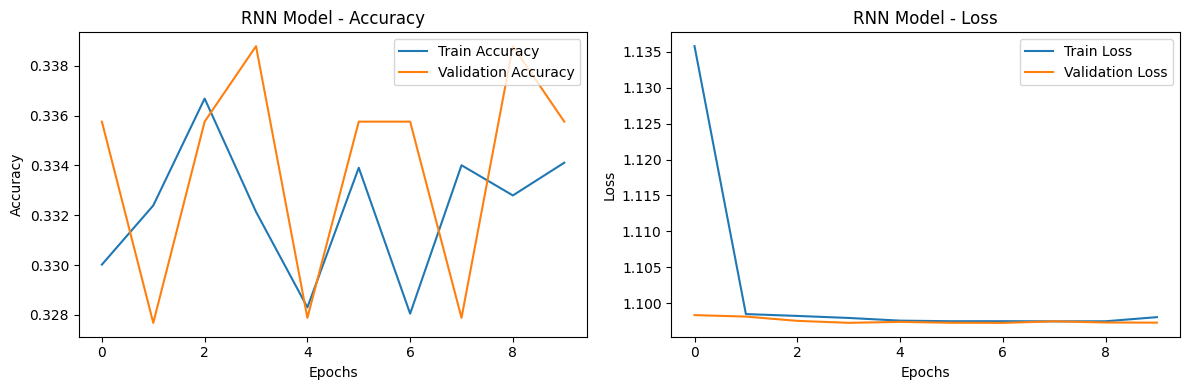

In [36]:
plot_history(rnn_Hist, "RNN Model")

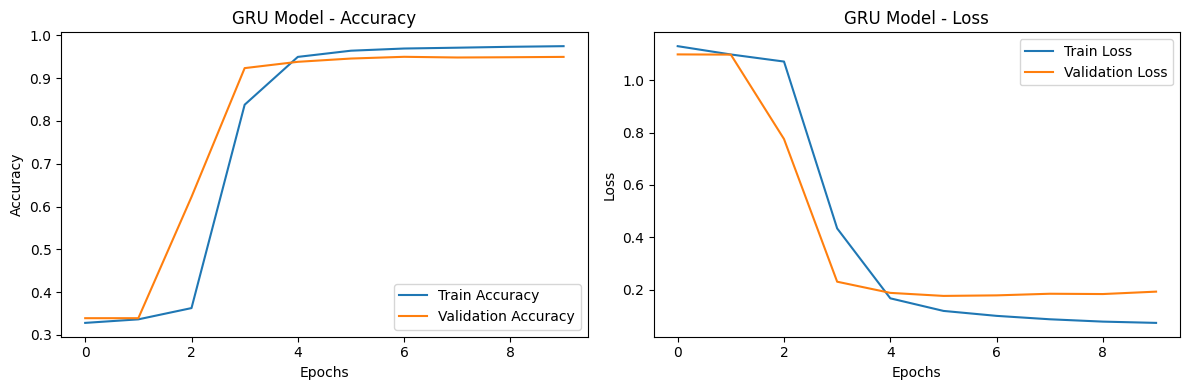

In [37]:
plot_history(gru_Hist, "GRU Model")

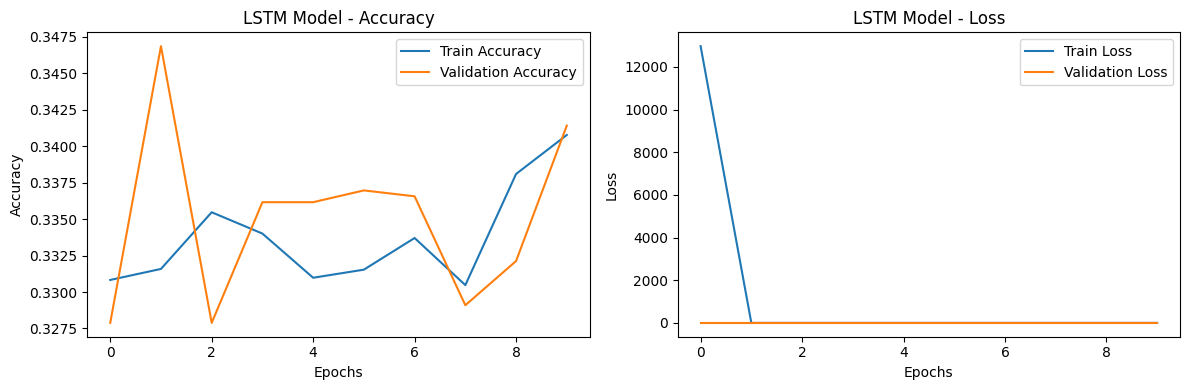

In [38]:
plot_history(lstm_Hist, "LSTM Model")

# **Methode 2**

In [40]:
# Sample 1000 rows from each class
sampled_data = data.groupby('type').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

# Check the new class distribution
sampled_class_counts = sampled_data['type'].value_counts()

<ipython-input-40-25ebcfdf9137>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('type').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)


In [41]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2999 non-null   object
 1   type      3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [42]:
sampled_class_counts

,count
type,
0,1000
1,1000
2,1000


<ipython-input-43-f346c3412870>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=sampled_data, palette='viridis')


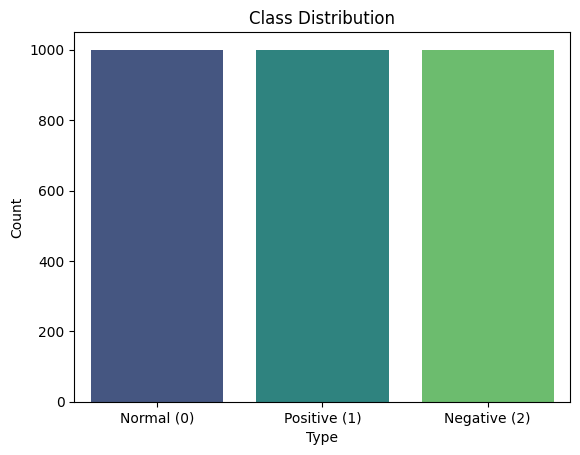

<ipython-input-43-f346c3412870>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='sentence_length', data=sampled_data, palette='viridis')


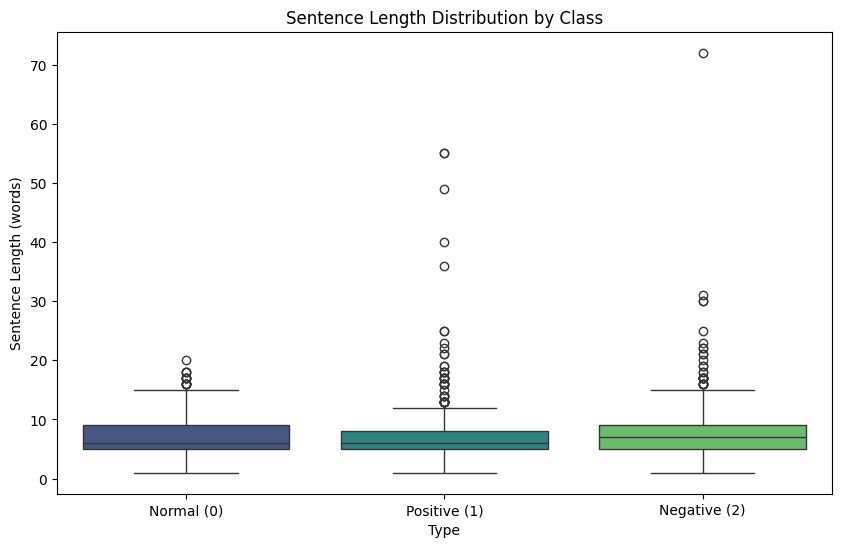

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
0,999.0,6.658659,3.429304,1.0,5.0,6.0,9.0,20.0
1,1000.0,7.238000,4.077497,1.0,5.0,6.0,8.0,55.0
2,1000.0,7.382000,4.063076,1.0,5.0,7.0,9.0,72.0


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize class distribution
sns.countplot(x='type', data=sampled_data, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Normal (0)', 'Positive (1)', 'Negative (2)'])
plt.show()

# Add a column for sentence lengths (number of words)
sampled_data['sentence_length'] = sampled_data['sentence'].dropna().apply(lambda x: len(str(x).split()))

# Sentence length distribution per class
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='sentence_length', data=sampled_data, palette='viridis')
plt.title('Sentence Length Distribution by Class')
plt.xlabel('Type')
plt.ylabel('Sentence Length (words)')
plt.xticks(ticks=[0, 1, 2], labels=['Normal (0)', 'Positive (1)', 'Negative (2)'])
plt.show()

# Summary statistics for sentence lengths
length_stats = sampled_data.groupby('type')['sentence_length'].describe()
length_stats

In [44]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for preprocessing
max_words = 10000  # Maximum number of unique words in the tokenizer
max_len = 50       # Maximum sequence length

# Drop rows with missing sentences
sampled_data = sampled_data.dropna(subset=['sentence'])

# Split data into features and labels
X = sampled_data['sentence']
y = sampled_data['type']

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Padding sequences
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Display shapes of train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2399, 50), (600, 50), (2399,), (600,))

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [46]:
# Encode labels if not already encoded
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [47]:
# Convert labels to categorical if it's a classification task with more than 2 classes
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [48]:
# Parameters
embedding_dim = 100  # Dimension of word embeddings
num_classes = y_train_cat.shape[1]  # Number of unique labels/classes

In [49]:
# 1. GRU Model
def build_gru_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        GRU(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        GRU(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model()
gru_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
# 2. LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 3. RNN Model
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        SimpleRNN(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Training Example for RNN Model
rnn_Hist2 = rnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3126 - loss: 1.1017 - val_accuracy: 0.3117 - val_loss: 1.1008
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3322 - loss: 1.0990 - val_accuracy: 0.3233 - val_loss: 1.0989
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3254 - loss: 1.0989 - val_accuracy: 0.3117 - val_loss: 1.0988
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3500 - loss: 1.0986 - val_accuracy: 0.3150 - val_loss: 1.0989
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3428 - loss: 1.0984 - val_accuracy: 0.3150 - val_loss: 1.0992
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3270 - loss: 1.1002 - val_accuracy: 0.3150 - val_loss: 1.1021
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3336 - loss: 1.0990 - val_accuracy: 0.3150 - val_loss: 1.0990
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3542 - loss: 1.0982 - val_accuracy: 0.3633 - v

In [53]:
# Training Example for GRU Model
gru_Hist2 = gru_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.3251 - loss: 1.0996 - val_accuracy: 0.3133 - val_loss: 1.0997
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3149 - loss: 1.0990 - val_accuracy: 0.3133 - val_loss: 1.0994
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3366 - loss: 1.0987 - val_accuracy: 0.3133 - val_loss: 1.1004
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.3474 - loss: 1.0981 - val_accuracy: 0.3150 - val_loss: 1.0992
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.3484 - loss: 1.0987 - val_accuracy: 0.3267 - val_loss: 1.1042
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.3367 - loss: 1.1000 - val_accuracy: 0.3150 - val_loss: 1.0990
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.3458 - loss: 1.0985 - val_accuracy: 0.3150 - val_loss: 1.0976
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.3381 - loss: 1.1147 - val_accuracy: 0.31

In [54]:
# Training Example for LSTM Model
lstm_Hist2 = lstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.3208 - loss: 1.0993 - val_accuracy: 0.3267 - val_loss: 1.0997
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.3260 - loss: 1.0993 - val_accuracy: 0.3267 - val_loss: 1.0991
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.3169 - loss: 1.0991 - val_accuracy: 0.3150 - val_loss: 1.0991
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3477 - loss: 1.0985 - val_accuracy: 0.3167 - val_loss: 1.0969
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.3233 - loss: 1.0989 - val_accuracy: 0.3150 - val_loss: 1.0985
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.3421 - loss: 1.1334 - val_accuracy: 0.3150 - val_loss: 1.0987
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.3378 - loss: 1.0992 - val_accuracy: 0.3167 - val_loss: 1.0988
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3332 - loss: 1.0984 - val_accuracy: 0.3167 - 

In [55]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate a model
def evaluate_model(model, X_test, y_test_enc):
    # Predict the probabilities for the test set
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class predictions
    y_pred = y_pred_probs.argmax(axis=1)

    # Generate classification report
    print("Classification Report:")
    # Convert label_encoder.classes_ to strings
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_test_enc, y_pred, target_names=target_names))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [56]:
# Evaluate RNN Model
print("\nEvaluating RNN Model:")
evaluate_model(rnn_model, X_test, y_test_enc)


Evaluating RNN Model:
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.67      0.01      0.02       196
           2       0.31      0.99      0.48       188

    accuracy                           0.32       600
   macro avg       0.33      0.33      0.17       600
weighted avg       0.32      0.32      0.16       600

Accuracy: 0.3150


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.315

In [57]:
# Evaluate GRU Model
print("\nEvaluating GRU Model:")
evaluate_model(gru_model, X_test, y_test_enc)


Evaluating GRU Model:
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.67      0.01      0.02       196
           2       0.31      0.99      0.48       188

    accuracy                           0.32       600
   macro avg       0.33      0.33      0.17       600
weighted avg       0.32      0.32      0.16       600

Accuracy: 0.3150


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.315

In [58]:
# Evaluate LSTM Model
print("\nEvaluating LSTM Model:")
evaluate_model(lstm_model, X_test, y_test_enc)


Evaluating LSTM Model:
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.67      0.01      0.02       196
           2       0.31      0.99      0.48       188

    accuracy                           0.32       600
   macro avg       0.33      0.33      0.17       600
weighted avg       0.32      0.32      0.16       600

Accuracy: 0.3150


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.315

In [59]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



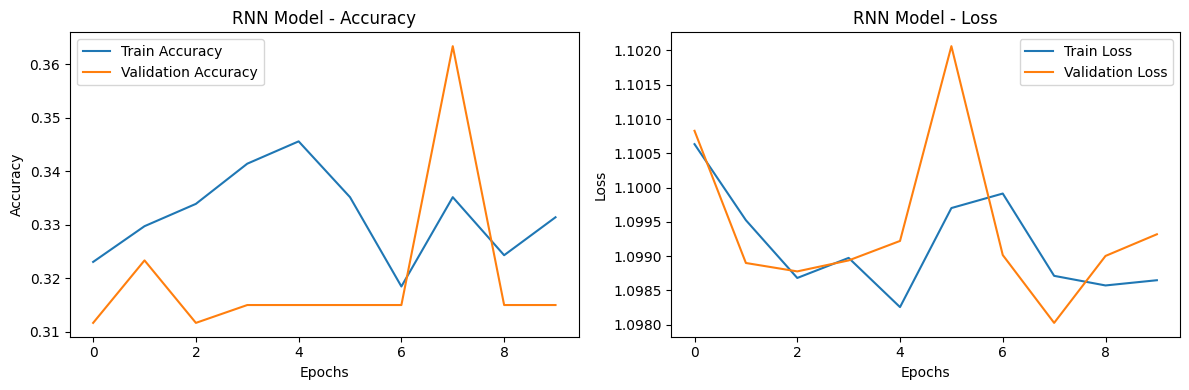

In [60]:
plot_history(rnn_Hist2, "RNN Model")

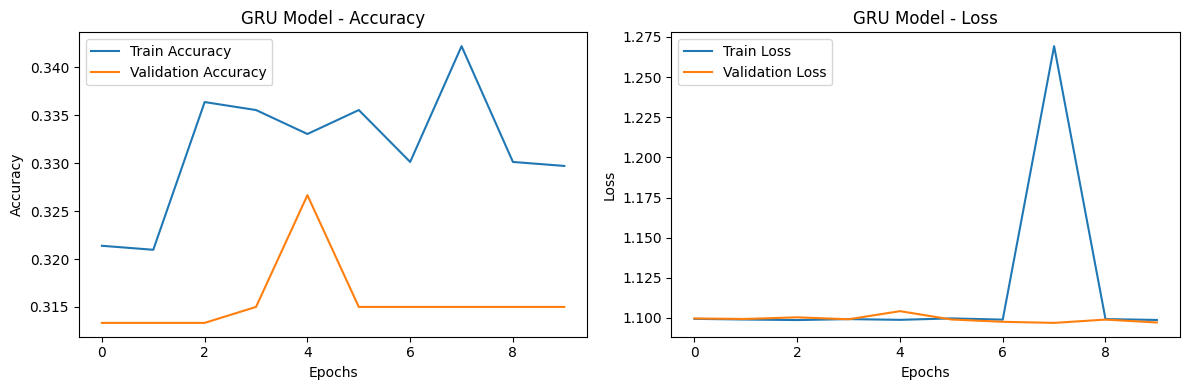

In [61]:
plot_history(gru_Hist2, "GRU Model")

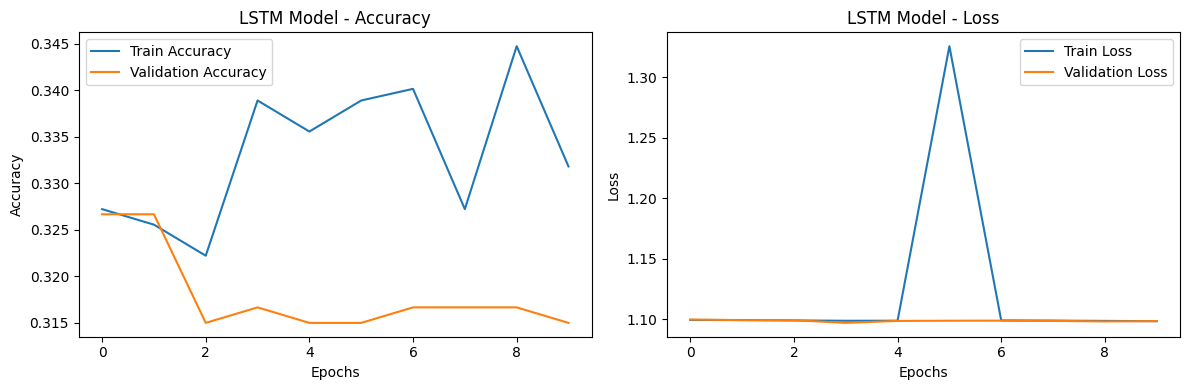

In [62]:
plot_history(lstm_Hist2, "LSTM Model")